In [1]:
from autumn.settings import Region, Models
from autumn.models.covid_19.constants import AGEGROUP_STRATA
from autumn.tools.project import get_project, run_project_locally
from autumn.tools import inputs
import matplotlib.pyplot as plt

params.yml


In [2]:
age_integers = [int(group) for group in AGEGROUP_STRATA]
model = Models.COVID_19

In [10]:
def summarise_population(project, region, axis):
    total_pops = inputs.get_population_by_agegroup(
        AGEGROUP_STRATA, 
        project.param_set.baseline["country"]["iso3"],
        project.param_set.baseline["population"]["region"], 
        year=project.param_set.baseline["population"]["year"]
    )
    axis.bar(age_integers, total_pops, width=4)
    axis.set_title(f"{region}, population {round(sum(total_pops) / 1e6, 3)} million")

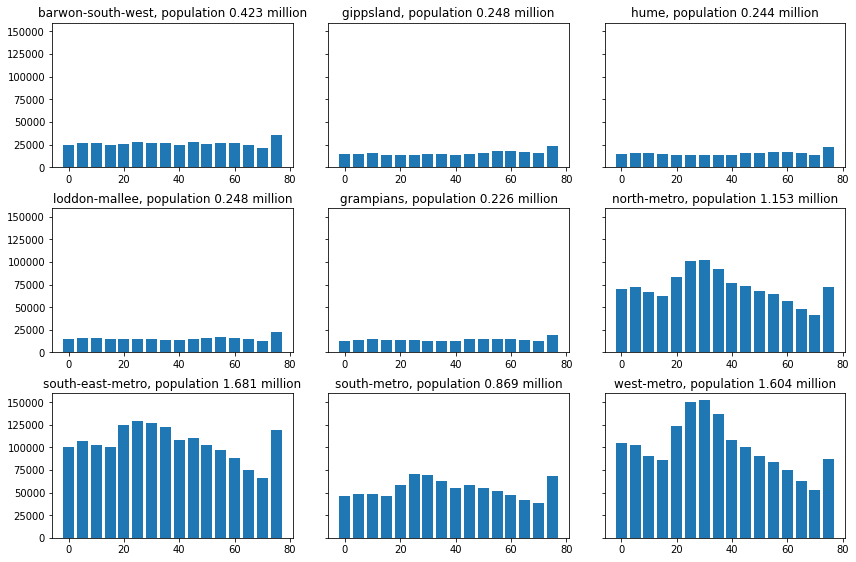

In [13]:
fig, axes = plt.subplots(3, 3, figsize=(12, 8), sharey="all")
fig.tight_layout(pad=2)

for i_ax, ax in enumerate(axes.reshape(-1)):
    region = Region.VICTORIA_SUBREGIONS[i_ax]
    project = get_project(model, region)
    summarise_population(project, region, ax)